In [262]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import pymzml
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [55]:
def get_user_param_value(param):
    if param.attrib['type'] == 'string':
        return param.attrib['value']
    elif param.attrib['type'] == 'int':
        return int(param.attrib['value'])
    elif param.attrib['type'] == 'float':
        return float(param.attrib['value'])
    else:
        assert False, param.attrib['type']

def from_user_param(node):
    r = {}
    for x in node.findall('UserParam'):
        r[x.attrib['name']] = get_user_param_value(x)
    return r

In [154]:
class XMLNode:
    def __init__(self, node):
        self.node = node
        self.d = {}
        self.d.update(node.attrib)
        self.d.update(from_user_param(node))

    def __getattr__(self, attr):
        if attr in self.d:
            return self.d[attr]
        return super().__getattr__(attr)

    def __getitem__(self, item):
        return self.d[item]

In [155]:
class XLMS_res:
    def __init__(self, filename = None):
        self.filename = filename
        if filename:
            self.xml = ET.parse(filename)

    @staticmethod
    def from_old(old):
        new = XLMS_res()
        new.filename = old.filename
        new.xml = old.xml
        return new

    def pep_matches(self):
        return self.xml.findall('IdentificationRun/PeptideIdentification')

    def all_spectrum(self):
        r = defaultdict(list)
        for pepid in self.pep_matches():
            # pephits = pepid.findall('PeptideHit')
            # # assert 1 <= len(pephits) <= 2, pephits
            # pephits = list(map(PepHit, pephits))
            r[pepid.attrib['spectrum_reference']].append(pepid)
        return r

res = XLMS_res.from_old(res)
res

In [39]:
psms = res.pep_matches()
len(psms)

148382

In [263]:
pepid = res.all_spectrum()
len(pepid)

17939

In [264]:
pepid['controllerType=0 controllerNumber=1 scan=2831']

[<Element 'PeptideIdentification' at 0x000001F27FBEA340>,
 <Element 'PeptideIdentification' at 0x000001F27FBED2B0>,
 <Element 'PeptideIdentification' at 0x000001F27FBEF8D0>,
 <Element 'PeptideIdentification' at 0x000001F27FBBE7F0>]

## Filter Matches

In [ ]:
def apply_pepid_filter(d, f):
    r = {k: [x for x in l if f(x)] for k, l in d.items()}
    return r

def filter_top2(x):
    return XMLNode(x).xl_rank <= 2

def apply_spectrum_filter(d, f):
    r = {k: l for k, l in d.items() if f(l)}
    return r

def filter_high_s2(l):
    if len(l) < 2:
        return False
    p2 = l[1]
    return XMLNode(p2.find('PeptideHit'))['OpenPepXL:score'] * 300 > 175

def filter_all_xl(l):
    for x in l:
        if XMLNode(x).xl_type != 'cross-link':
            return False
    return True

In [57]:
pepid_top2 = apply_pepid_filter(pepid, filter_top2)

In [58]:
pepid_top2['controllerType=0 controllerNumber=1 scan=2831']

[<Element 'PeptideIdentification' at 0x000001F27FBEA340>,
 <Element 'PeptideIdentification' at 0x000001F27FBED2B0>]

In [63]:
pepid_high_s2 = apply_spectrum_filter(pepid_top2, filter_high_s2)
len(pepid_high_s2)

397

In [137]:
pepid_high_s2 = apply_spectrum_filter(pepid_high_s2, filter_all_xl)
len(pepid_high_s2)

256

In [138]:
pepid_high_s2.keys()

dict_keys(['controllerType=0 controllerNumber=1 scan=5236', 'controllerType=0 controllerNumber=1 scan=5710', 'controllerType=0 controllerNumber=1 scan=5964', 'controllerType=0 controllerNumber=1 scan=6052', 'controllerType=0 controllerNumber=1 scan=6131', 'controllerType=0 controllerNumber=1 scan=6336', 'controllerType=0 controllerNumber=1 scan=7110', 'controllerType=0 controllerNumber=1 scan=8069', 'controllerType=0 controllerNumber=1 scan=8115', 'controllerType=0 controllerNumber=1 scan=8562', 'controllerType=0 controllerNumber=1 scan=8817', 'controllerType=0 controllerNumber=1 scan=9028', 'controllerType=0 controllerNumber=1 scan=9191', 'controllerType=0 controllerNumber=1 scan=9200', 'controllerType=0 controllerNumber=1 scan=9213', 'controllerType=0 controllerNumber=1 scan=9223', 'controllerType=0 controllerNumber=1 scan=9255', 'controllerType=0 controllerNumber=1 scan=9256', 'controllerType=0 controllerNumber=1 scan=9270', 'controllerType=0 controllerNumber=1 scan=9312', 'controll

In [82]:
ns = 'http://psi.hupo.org/ms/mzml'
nsmap = {'': ns}

In [111]:
specref_reg = re.compile('.* scan=(\d+)')

class mzML:
    def __init__(self, filename = None):
        self.filename = filename
        if filename:
            self.mzml = pymzml.run.Reader(filename)

    @staticmethod
    def from_old(old):
        new = mzML()
        new.filename = old.filename
        new.mzml = old.mzml
        return new

    def find(self, spec_ref):
        m = specref_reg.match(spec_ref)
        if not m:
            return None
        id = int(m.group(1))
        return self.mzml[id]



In [112]:
mzml = mzML('../spec/alban/20210702_L1_UM5_alban001_SA_EXT00_Ilse_fbn_dss2_450mm.mzML')
mzml

[Warning] Not index found and build_index_from_scratch is False


In [113]:
mzml.find('controllerType=0 controllerNumber=1 scan=18105')

<__main__.Spectrum object with native ID 18105 at 0x1f46027b610>

## Spectrum

In [219]:
class Spectrum:
    def __init__(self, spec):
        self.spec = spec

    def peaks(self):
        return self.spec.peaks('raw')
        
    def plot(self, ax = None):
        if not ax:
            plt.figure()
            ax = plt.subplot(1, 1, 1)
        bars = self.peaks()
        ax.bar(bars[:, 0], bars[:, 1], color='red')
        # ax.set_ylim([0, 2.5e5])
        ax.set_xlim([0, 800])

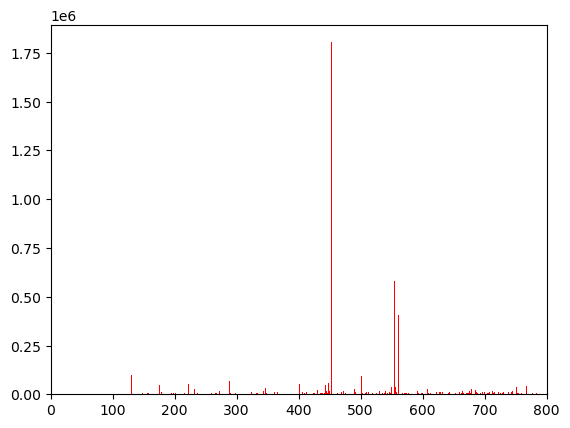

In [220]:
spec = Spectrum(mzml.find('controllerType=0 controllerNumber=1 scan=5236'))
spec.plot()

In [196]:
spec.peaks()[:,1].argmax()

169

In [197]:
spec.peaks()[169]

array([4.52997833e+02, 1.80468550e+06])

In [201]:
spec.peaks()[:,0]

array([ 120.08093262,  123.17110443,  124.93912506,  126.09191132,
        128.57928467,  129.0660553 ,  129.10247803,  130.0500946 ,
        130.08651733,  130.10585022,  130.11076355,  131.09040833,
        133.04328918,  134.64541626,  135.03924561,  136.07601929,
        139.08731079,  145.23434448,  146.08103943,  147.10694885,
        147.11315918,  148.116745  ,  155.08166504,  156.07699585,
        157.10906982,  157.13383484,  158.09280396,  159.07722473,
        175.07199097,  175.11949158,  176.12333679,  179.04901123,
        195.08818054,  198.12423706,  199.10845947,  201.12388611,
        203.06730652,  207.08795166,  212.10392761,  213.08760071,
        213.12492371,  213.60926819,  216.13517761,  222.12245178,
        222.62425232,  229.11943054,  232.0760498 ,  232.14134216,
        234.1461792 ,  237.09910583,  237.13626099,  241.08345032,
        259.09381104,  261.1567688 ,  262.11791992,  266.12619019,
        267.17184448,  271.12384033,  271.17819214,  272.10705

## Plot XLMS

In [161]:
def split_string(s):
    """
    Splits the string 's' by '|' character, but does not break strings within quotes.
    
    Args:
    s (str): The string to be split.

    Returns:
    List[str]: A list of substrings.
    """
    result = []
    current = ''
    in_quote = False
    escape = False

    for char in s:
        if char == '"' and not escape:
            in_quote = not in_quote
        if char == '|' and not in_quote:
            result.append(current)
            current = ''
        else:
            current += char
        escape = (char == '\\' and not escape)

    # Add the last segment
    if current:
        result.append(current)

    return result


In [221]:
def find_intensity(x, spec):
    y = spec[np.isclose(spec[:, 0], x)][0, 1]
    # print(y)
    return y

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


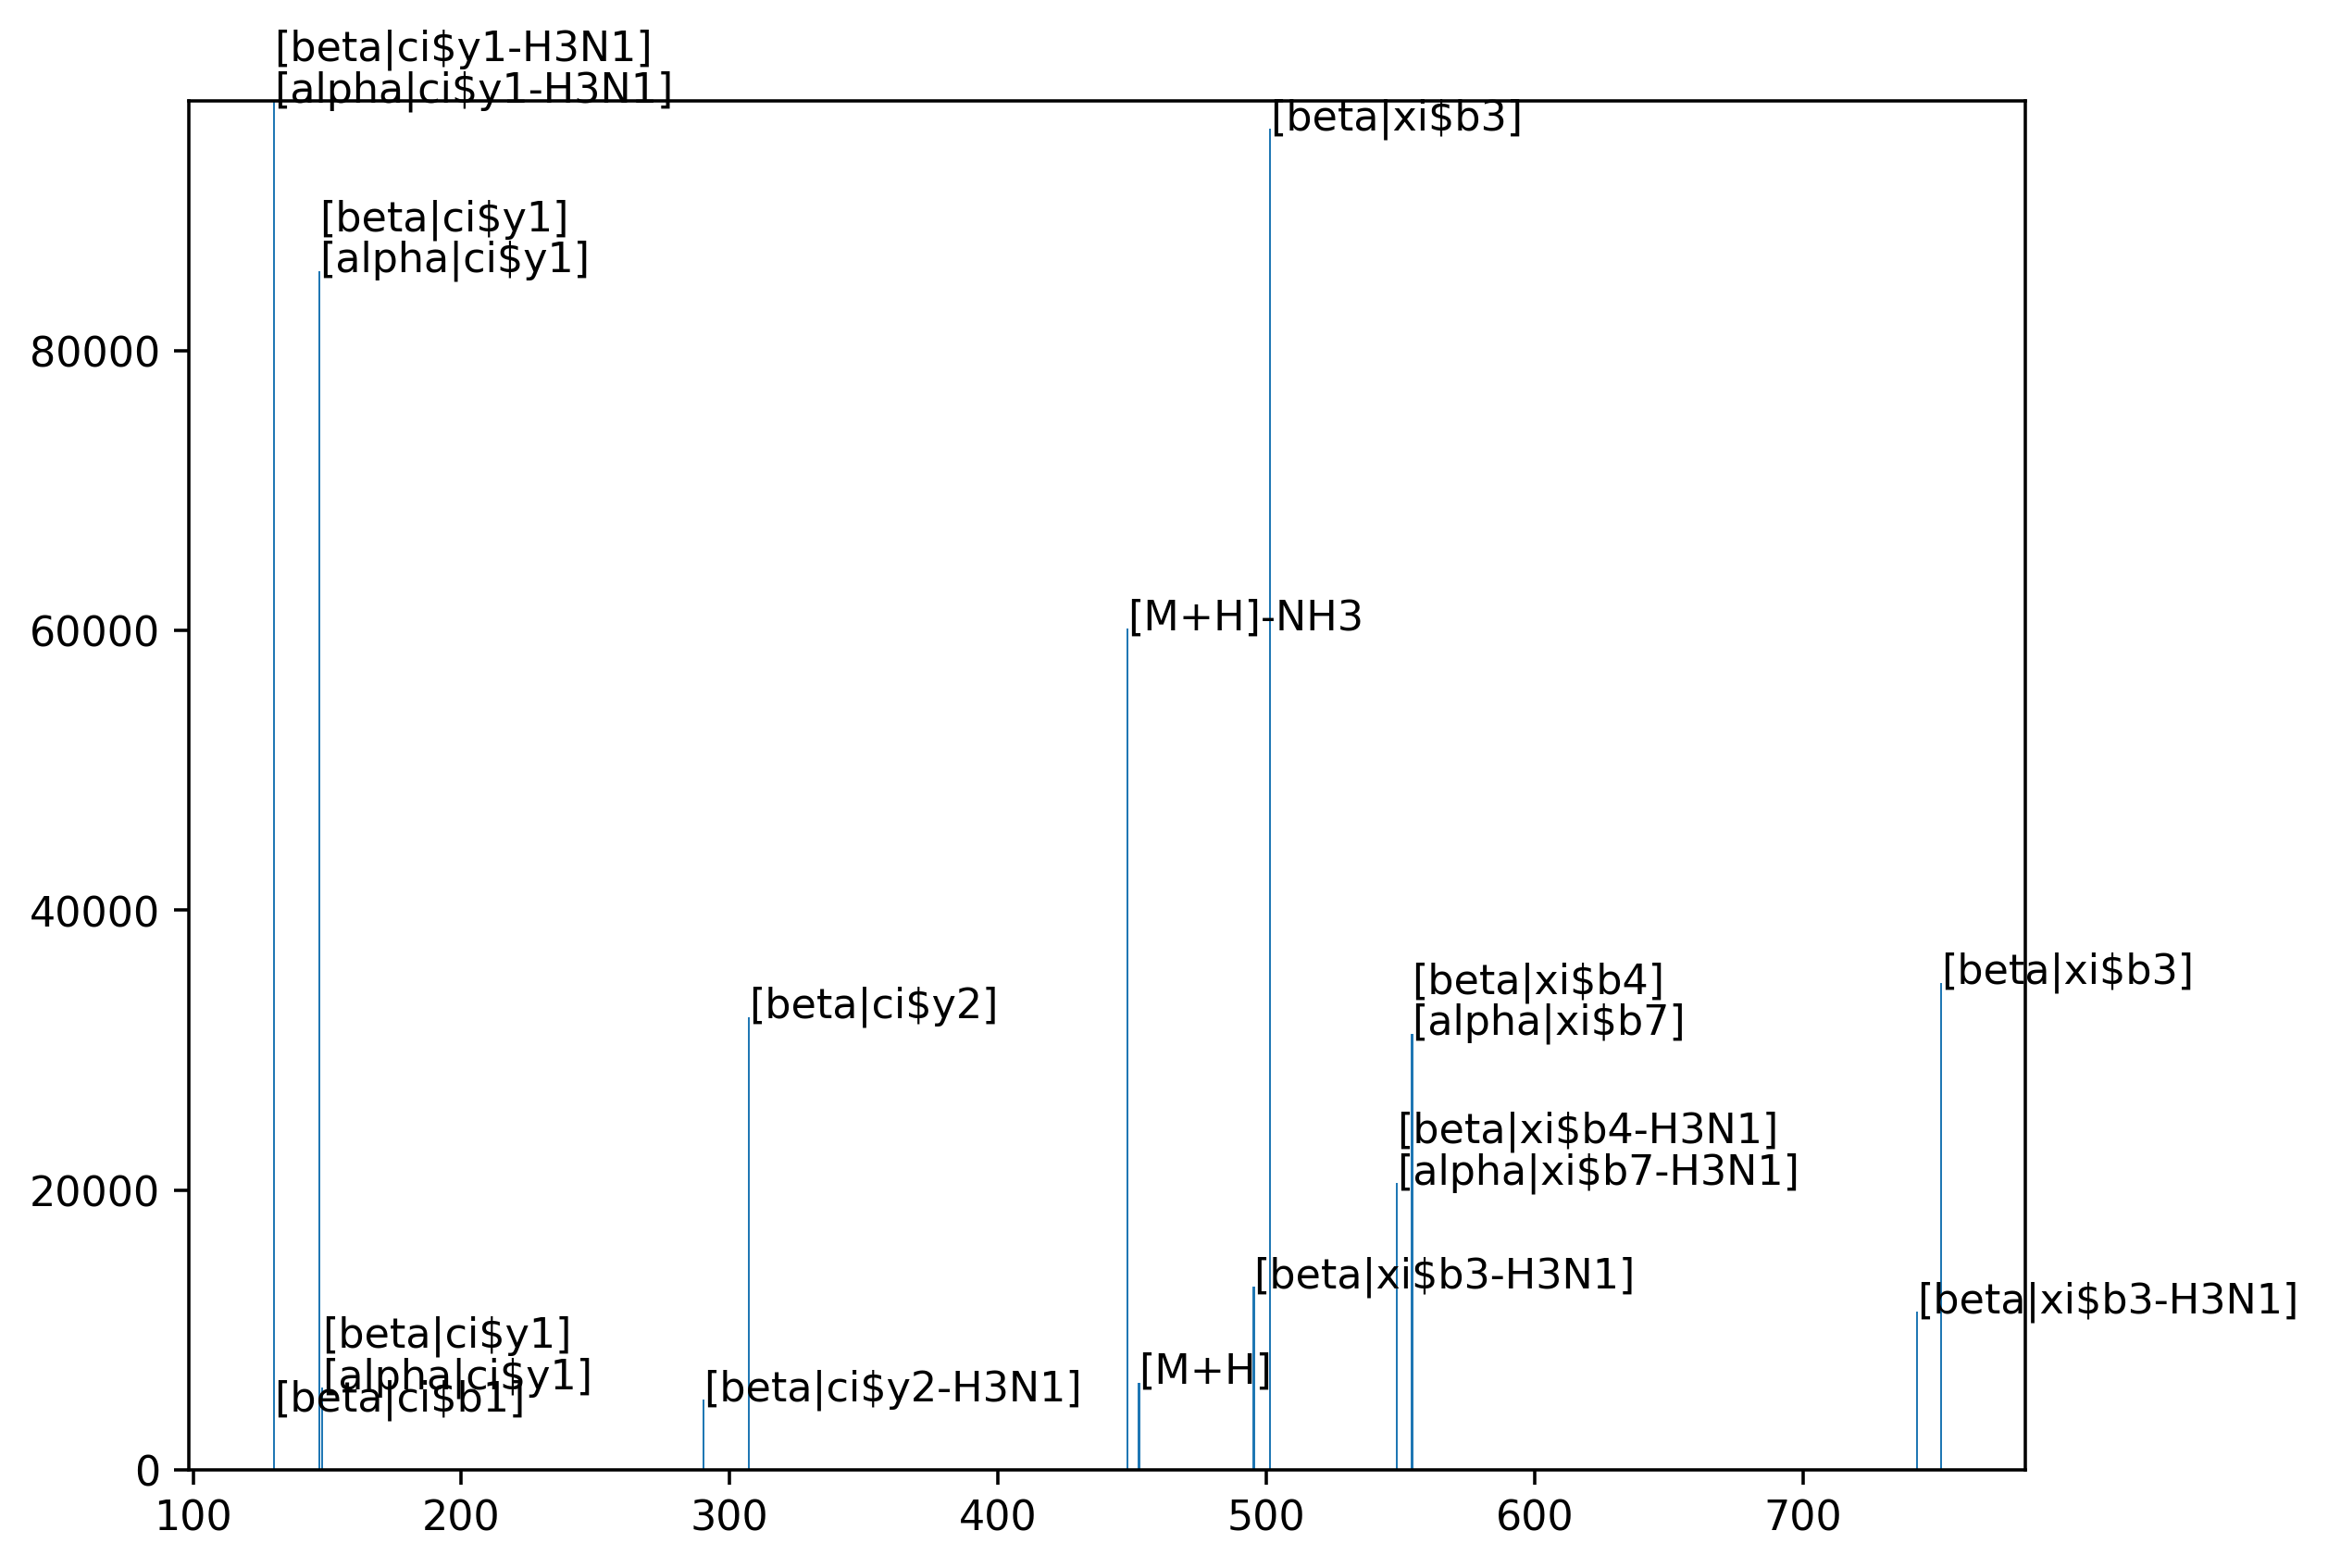

In [258]:
class XLMS_id:
    def __init__(self, pepid):
        self.pepid = pepid

    def plot(self, spec, ax = None):
        if not ax:
            ax = plt.subplot(1, 1, 1)

        alpha = XMLNode(self.pepid.find('PeptideHit[1]'))
        beta = XMLNode(self.pepid.find('PeptideHit[2]'))

        # print(alpha, beta)
        # print(alpha.fragment_annotation)

        frags = []
        for frag in split_string(alpha.fragment_annotation):
            # print(frag)
            x, y, _, label = frag.split(',')
            x = eval(x)
            y = find_intensity(x, spec.peaks())
            frags.append((x, y, eval(label)))

        frags = pd.DataFrame(frags)
        print(frags)
        
        ax.bar(frags[0], frags[1])

        ax.set_ylim([0, frags[1].max()])

        counts = defaultdict(int)
        for i, (x, y, label) in frags.iterrows():
            yoff = counts[x] * 1
            counts[x] += 1
            ax.annotate(label, (x, y), (0, yoff), xycoords='data', textcoords='offset fontsize')

plt.figure(figsize=[8, 6], dpi=320)
xlms_id = XLMS_id(pepid_high_s2['controllerType=0 controllerNumber=1 scan=5236'][0])
xlms_id.plot(spec)

## Plot Both

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


<Figure size 640x480 with 0 Axes>

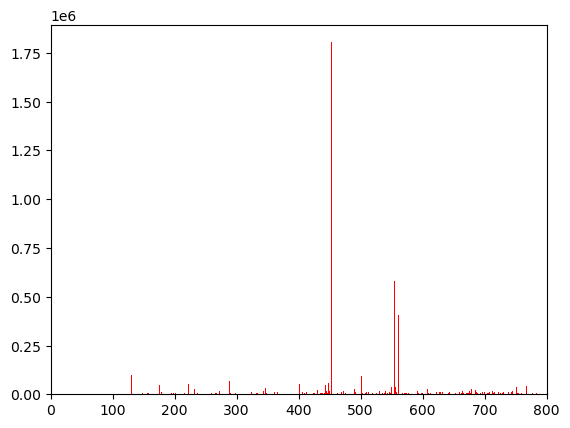

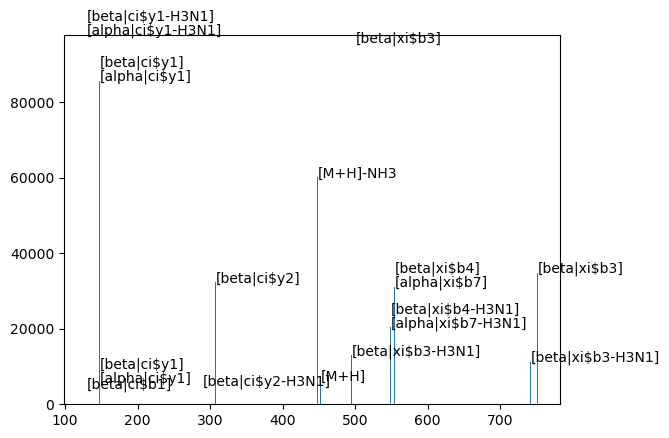

In [259]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=5236'

# ax = plt.subplot(1, 1, 1)
plt.figure()
spec = Spectrum(mzml.find(spec_ref))
spec.plot()

plt.figure()
xlms_id = XLMS_id(pepid_high_s2[spec_ref][0])
xlms_id.plot(spec)

In [275]:
XMLNode(pepid_high_s2[spec_ref][1].find('PeptideHit'))['OpenPepXL:score'] * 300

177.7652125795104

In [284]:
XMLNode(pepid_high_s2[spec_ref][0].find('PeptideHit[1]')).d

{'score': '0.594696488208306',
 'sequence': 'VDKKVEPK',
 'charge': '4',
 'aa_before': 'K',
 'aa_after': 'S',
 'start': '93',
 'end': '100',
 'protein_refs': 'PH_8',
 'fragment_annotation': '130.050094604492188,2.363441046327353e-03,1,"[beta|ci$b1]"|130.086517333984375,0.054196480661631,1,"[alpha|ci$y1-H3N1]"|130.086517333984375,0.054196480661631,1,"[beta|ci$y1-H3N1]"|147.1131591796875,0.047475598752499,1,"[alpha|ci$y1]"|147.1131591796875,0.047475598752499,1,"[beta|ci$y1]"|148.116744995117188,3.253305563703179e-03,1,"[alpha|ci$y1]"|148.116744995117188,3.253305563703179e-03,1,"[beta|ci$y1]"|290.11834716796875,2.772539621219039e-03,1,"[beta|ci$y2-H3N1]"|307.144622802734375,0.0179353505373,1,"[beta|ci$y2]"|448.244903564453125,0.241945222020149,4,"[M+H]-NH3"|452.4986572265625,2.741323232650757,4,"[M+H]"|495.28045654296875,0.022277658805251,3,"[beta|xi$b3-H3N1]"|501.281707763671875,0.112767525017262,3,"[beta|xi$b3]"|548.62249755859375,0.071265533566475,3,"[alpha|xi$b7-H3N1]"|548.622497558593

In [283]:
XMLNode(pepid_high_s2[spec_ref][1].find('PeptideHit[1]')).d

{'score': '0.592550708598368',
 'sequence': 'VDKKVEPK',
 'charge': '4',
 'aa_before': 'K',
 'aa_after': 'S',
 'start': '93',
 'end': '100',
 'protein_refs': 'PH_8',
 'fragment_annotation': '130.050094604492188,2.363441046327353e-03,1,"[beta|ci$b1]"|130.086517333984375,0.054196480661631,1,"[alpha|ci$y1-H3N1]"|130.086517333984375,0.054196480661631,1,"[beta|ci$y1-H3N1]"|147.1131591796875,0.047475598752499,1,"[alpha|ci$y1]"|147.1131591796875,0.047475598752499,1,"[beta|ci$y1]"|148.116744995117188,3.253305563703179e-03,1,"[alpha|ci$y1]"|148.116744995117188,3.253305563703179e-03,1,"[beta|ci$y1]"|290.11834716796875,2.772539621219039e-03,1,"[beta|ci$y2-H3N1]"|307.144622802734375,0.0179353505373,1,"[beta|ci$y2]"|448.244903564453125,0.241945222020149,4,"[M+H]-NH3"|452.4986572265625,2.741323232650757,4,"[M+H]"|495.28045654296875,0.022277658805251,3,"[beta|xi$b3-H3N1]"|501.281707763671875,0.112767525017262,3,"[beta|xi$b3]"|548.62249755859375,0.071265533566475,3,"[alpha|xi$b7-H3N1]"|548.622497558593

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


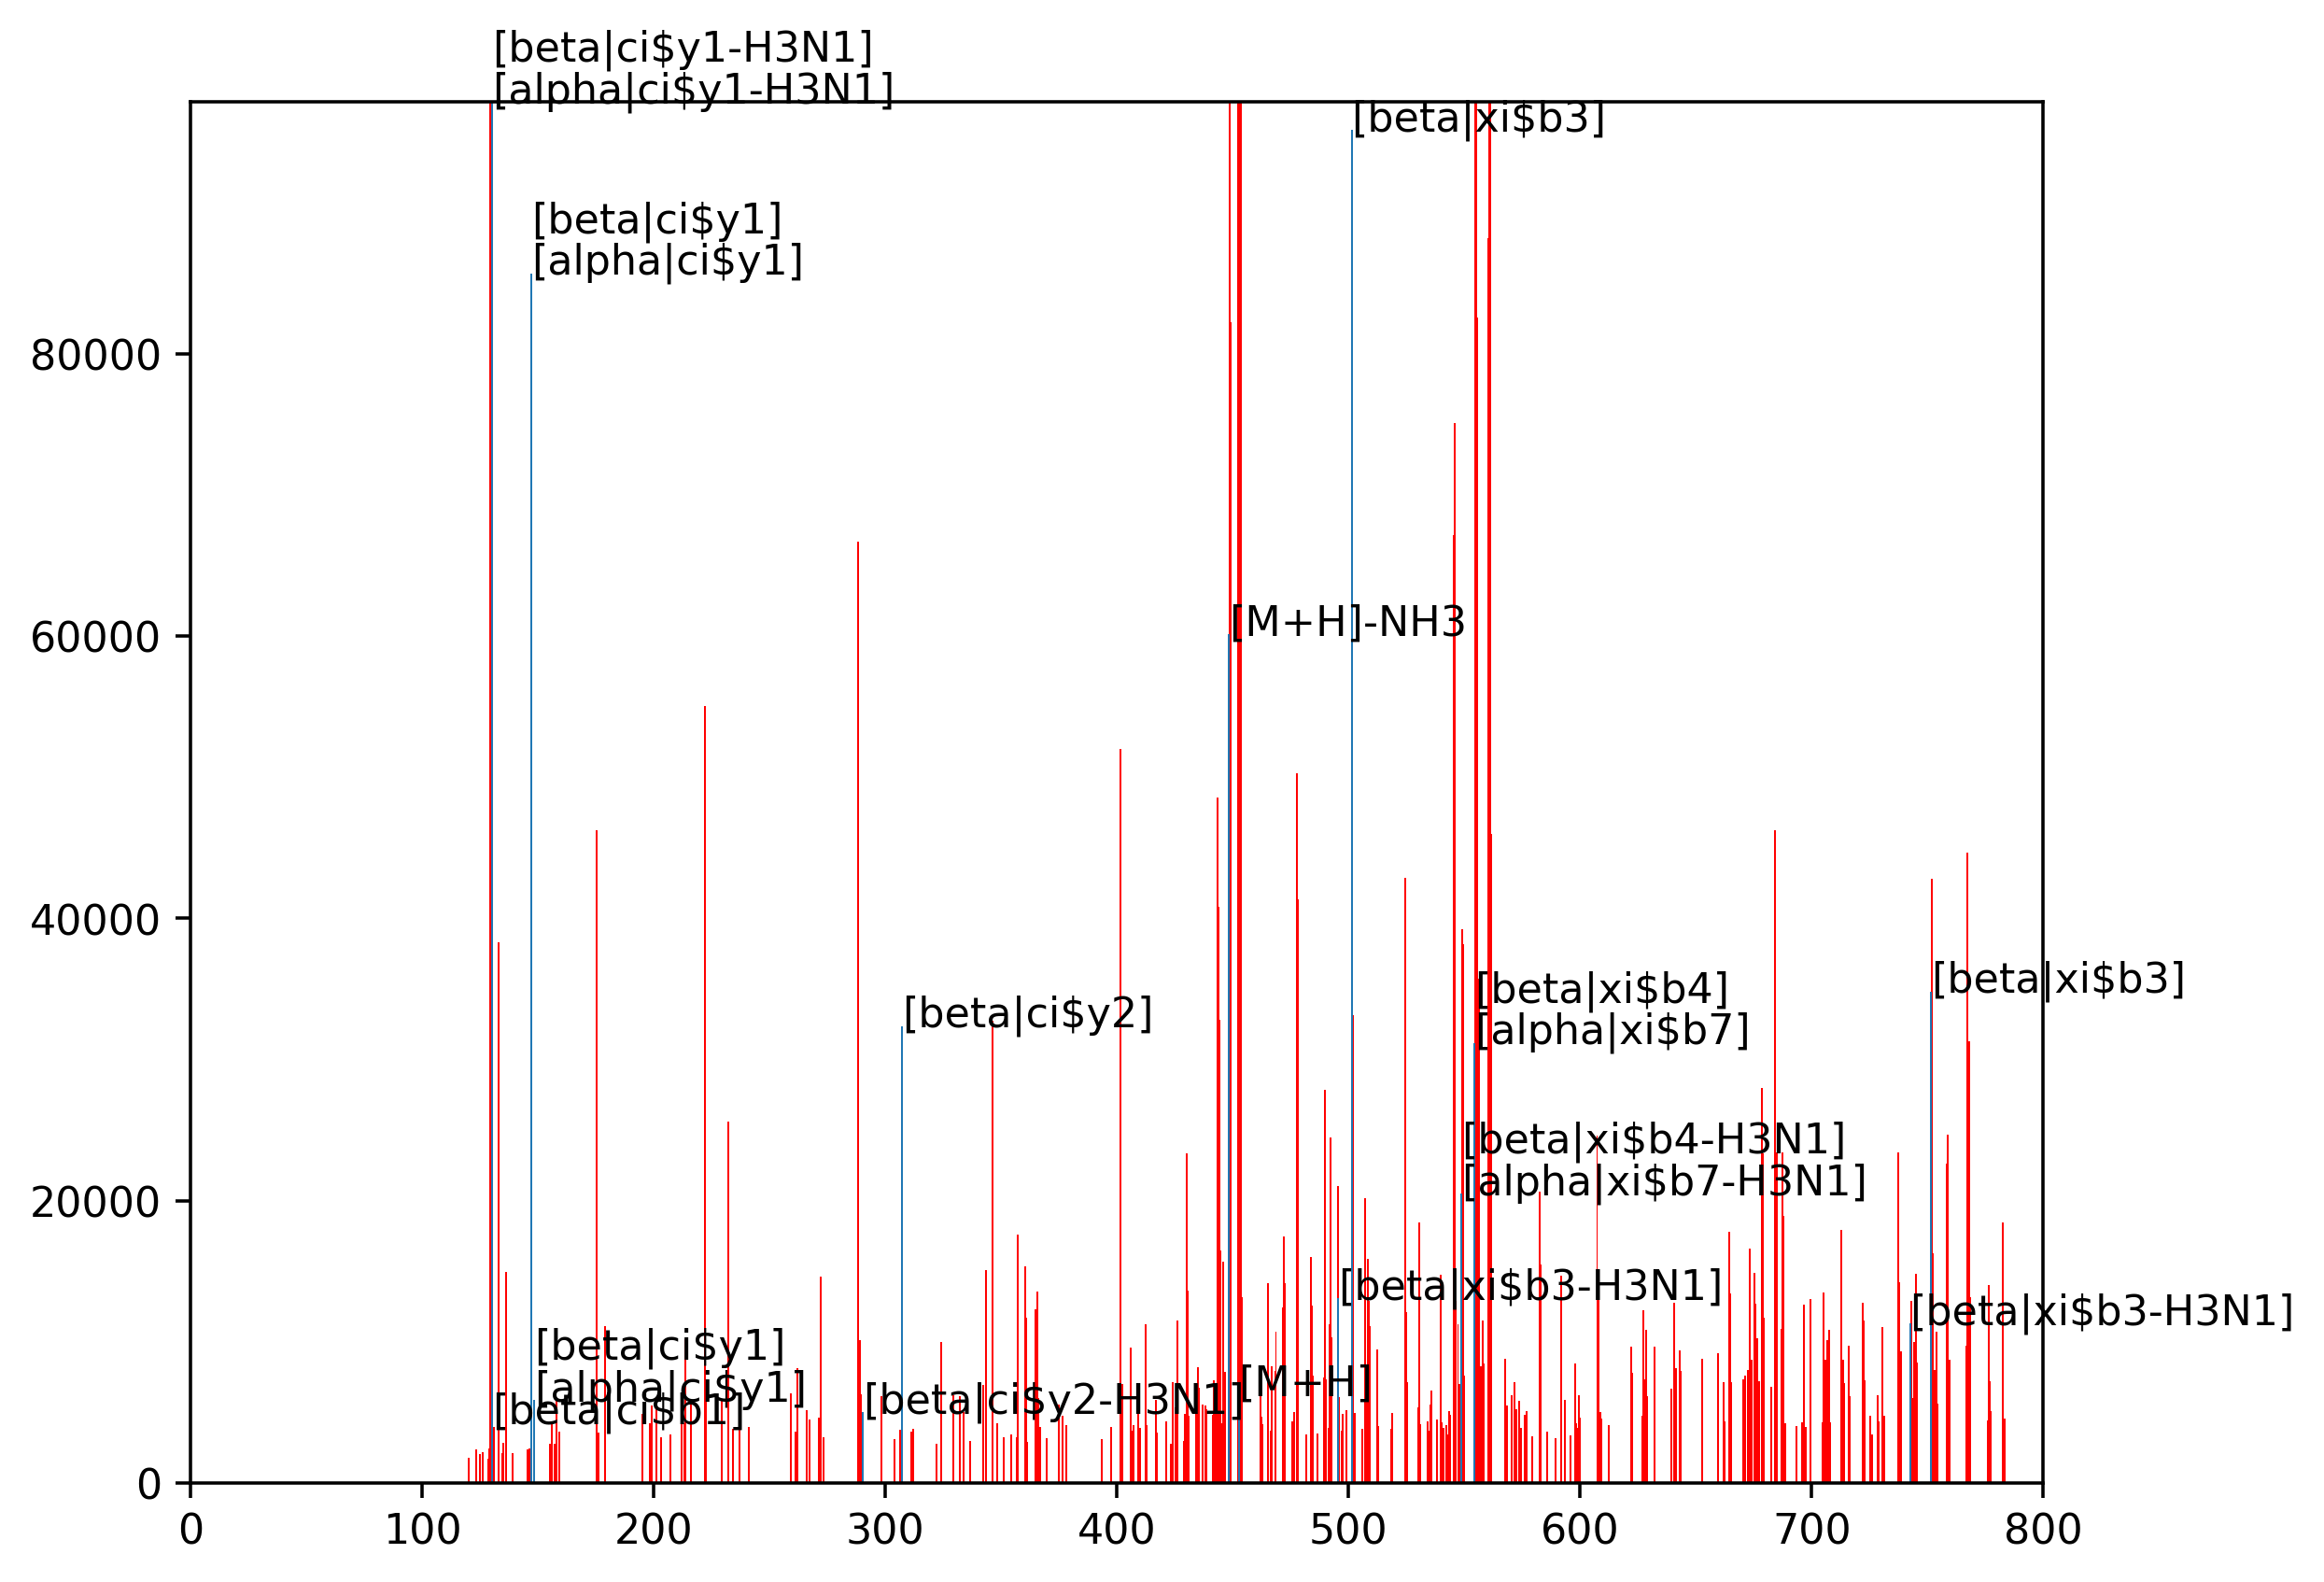

In [260]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=5236'

plt.figure(figsize=[8, 6], dpi=320)
ax = plt.subplot(1, 1, 1)

spec = Spectrum(mzml.find(spec_ref))
spec.plot(ax)

xlms_id = XLMS_id(pepid_high_s2[spec_ref][0])
xlms_id.plot(spec, ax)

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


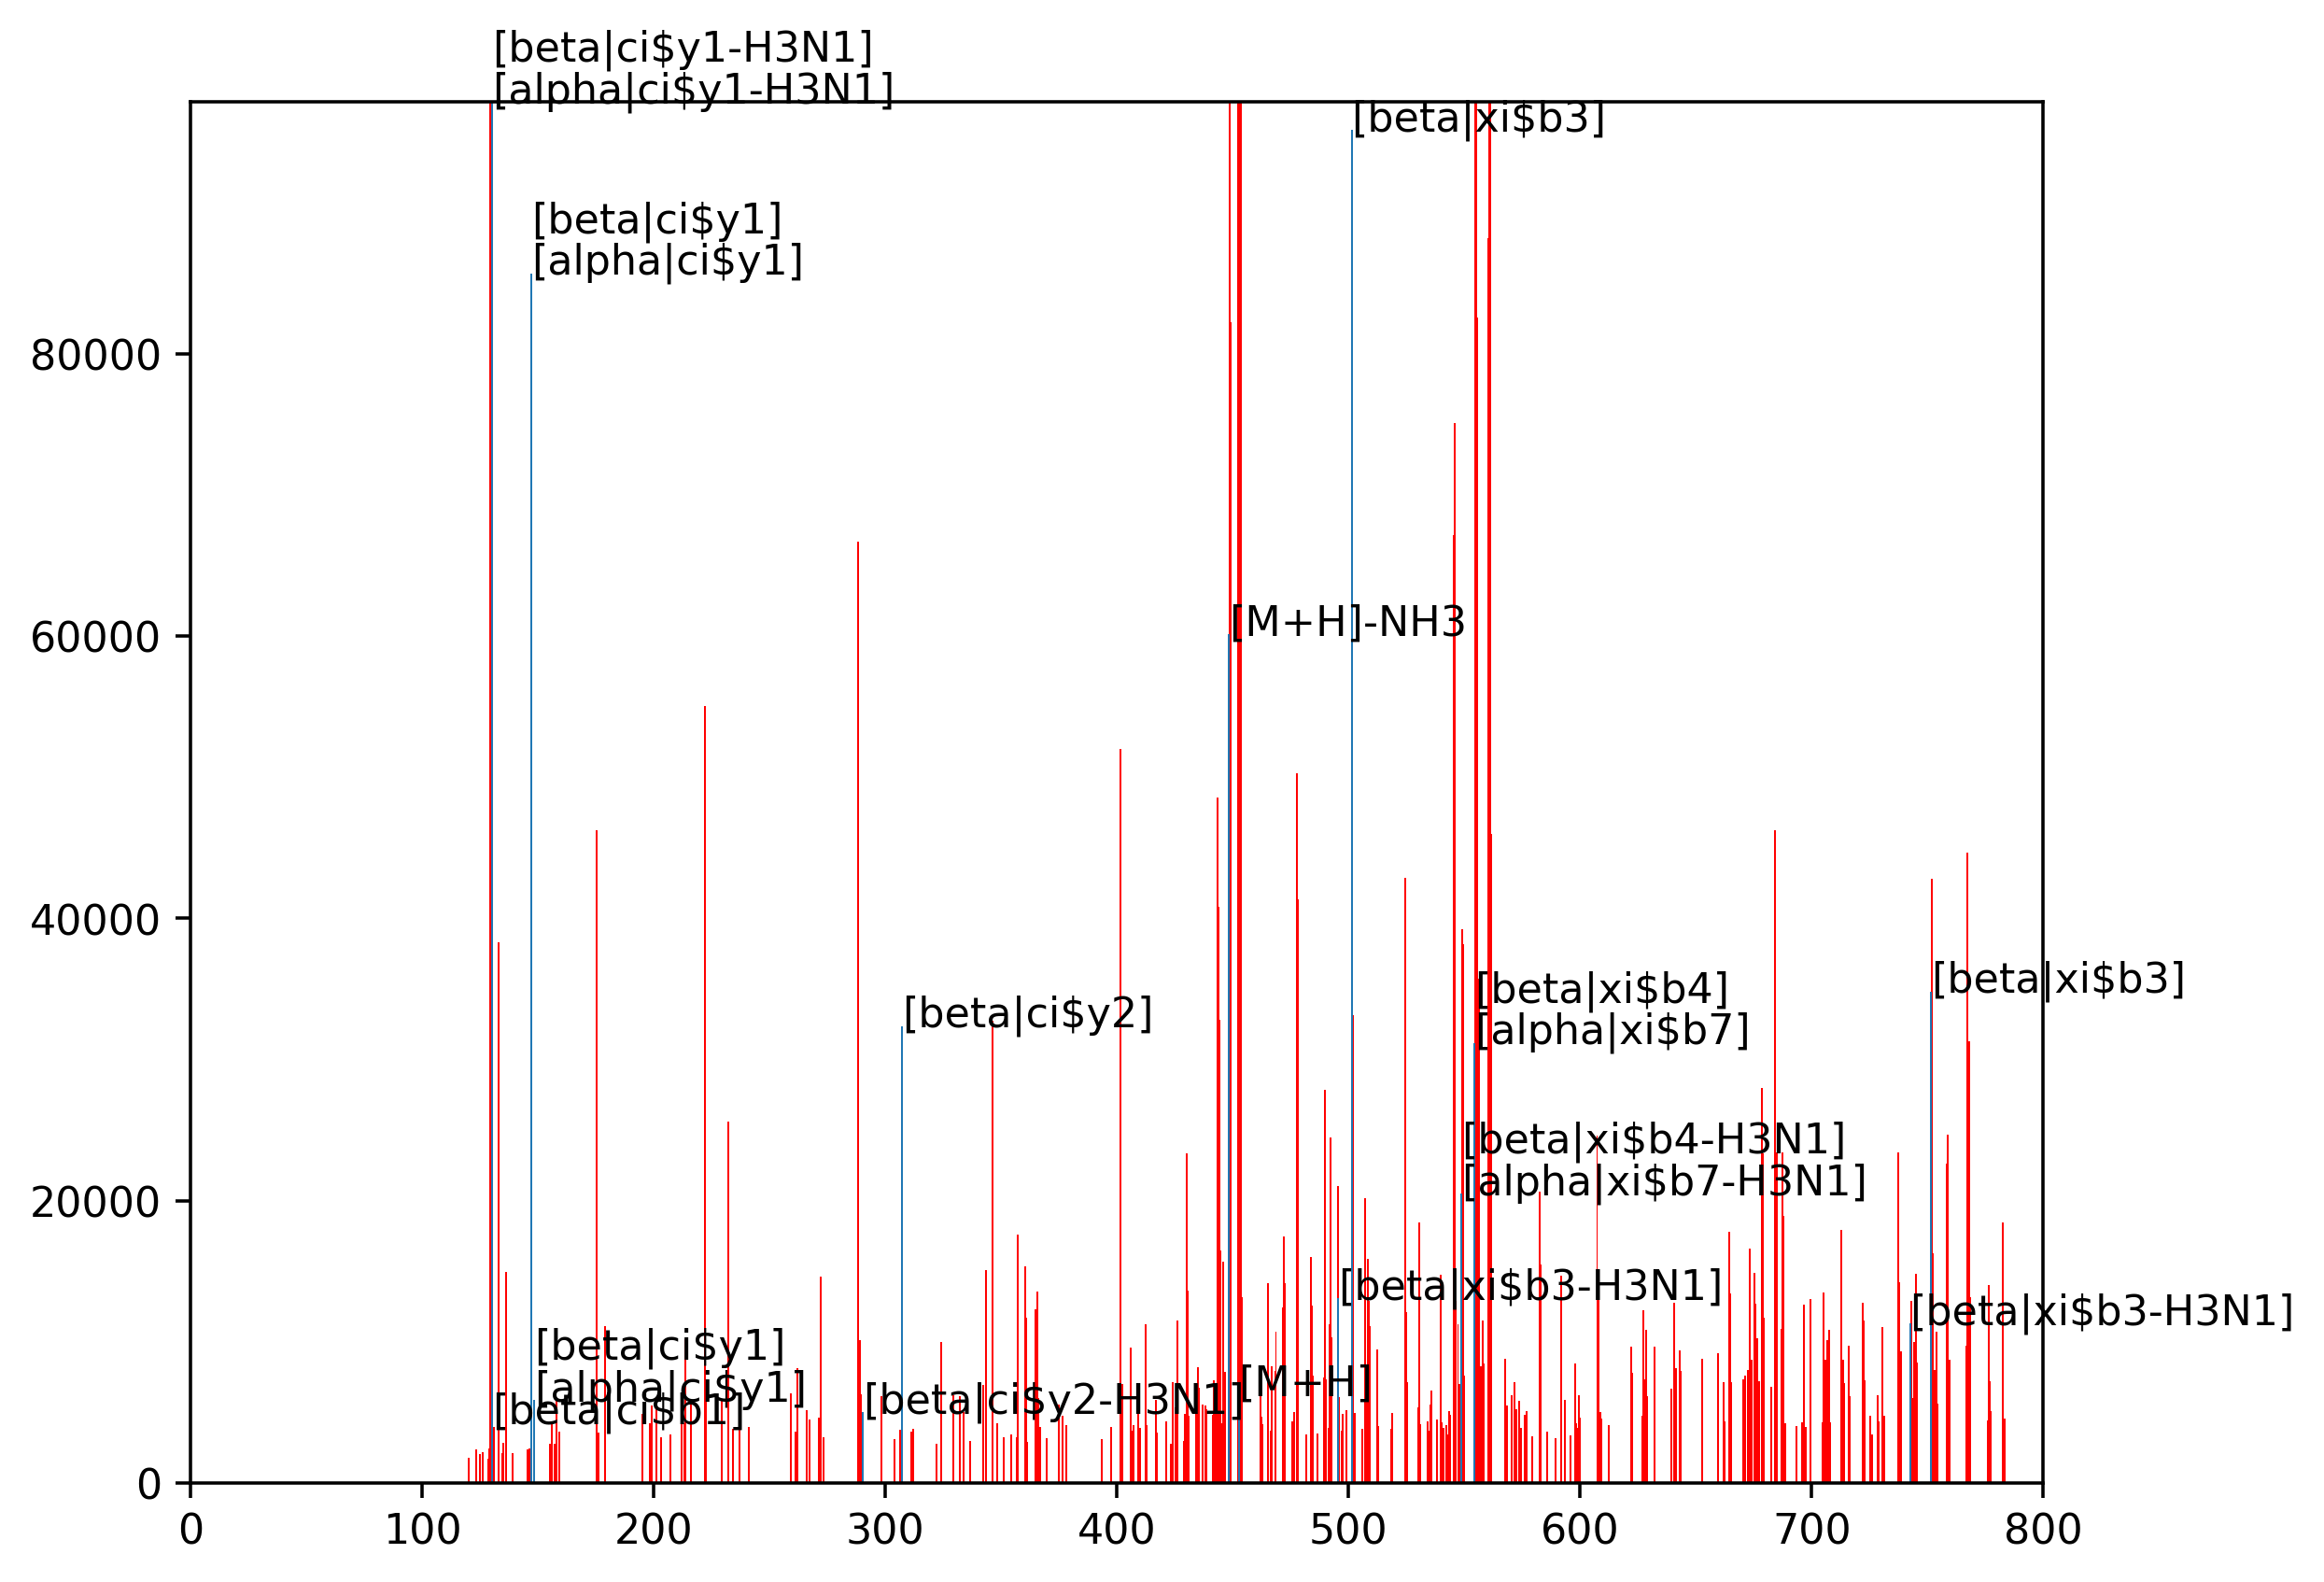

In [276]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=5236'

plt.figure(figsize=[8, 6], dpi=320)
ax = plt.subplot(1, 1, 1)

spec = Spectrum(mzml.find(spec_ref))
spec.plot(ax)

xlms_id = XLMS_id(pepid_high_s2[spec_ref][1])
xlms_id.plot(spec, ax)

In [261]:

xlms_id = XLMS_id(pepid_high_s2[spec_ref][1])
xlms_id.plot(spec, ax)

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


In [244]:
spec.xml.findall(f'run/spectrumList/spectrum', nsmap)

AttributeError: 'Spectrum' object has no attribute 'xml'

In [ ]:
def 

In [7]:
res = XLMS_res('../results/openpepxllf/alban/20210702_L1_UM5_alban001_SA_EXT00_Ilse_fbn_dss2_450mm.idXML')
res.xml

In [11]:
new_res = XLMS_res.from_old(res)
new_res

In [31]:
root = res.xml
x = root.find('IdentificationRun/PeptideIdentification')

In [127]:
x.find('PeptideHit[1]')

<Element 'PeptideHit' at 0x000001F27FBEA3E0>

In [125]:
x.findall('PeptideHit')

[<Element 'PeptideHit' at 0x000001F27FBEA3E0>,
 <Element 'PeptideHit' at 0x000001F27FBECAE0>]

In [36]:
x.attrib

{'score_type': 'OpenPepXL:score',
 'higher_score_better': 'true',
 'significance_threshold': '0.0',
 'MZ': '655.048889160156023',
 'RT': '756.125406943002076',
 'spectrum_reference': 'controllerType=0 controllerNumber=1 scan=2831'}